In [2]:
import timm

# model = timm.create_model('vit_base_patch16_dinov3.lvd1689m', pretrained=True).cuda()
# model = timm.create_model('vit_base_patch16_dinov3.lvd1689m', pretrained=True).cuda()
# model = timm.create_model('vit_base_patch32_clip_224.laion2b_ft_in1k', pretrained=True).cuda()
model = timm.create_model('vit_base_patch16_clip_224.openai', pretrained=True).cuda()



data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [3]:
def unnorm_image(img):
    return  (img - img.min()) / (img.max() - img.min() + 1e-8)

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("./trumpet.jpg").convert("RGB")
# img = Image.open("dog.png").convert("RGB")
# img = Image.open("forest.png").convert("RGB")
x = transforms(img).unsqueeze(0).cuda()
x.requires_grad = True

In [51]:
import torch

if x.grad is not None:
    x.grad.zero_()

preds = model(x)
clid = torch.argmax(preds)
preds[0, clid].backward()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-25.068575..10.118268].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

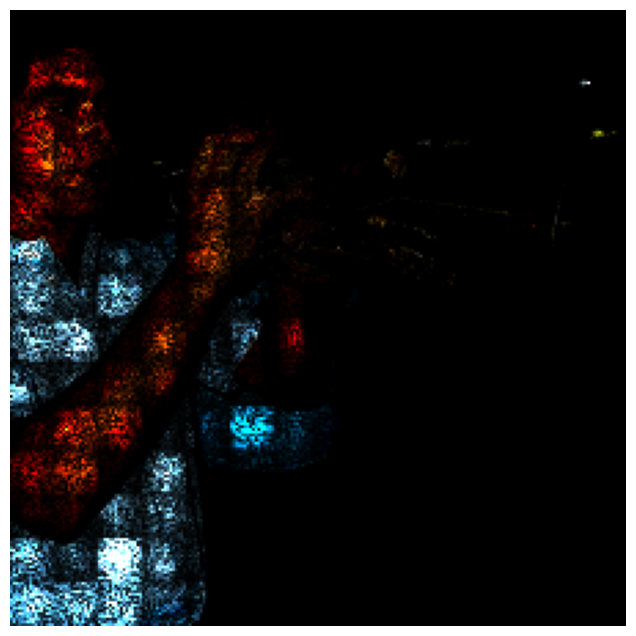

In [59]:
ex = x.detach() * x.grad.data.mean(dim=1).abs() * 100

plt.figure(figsize=(8,8))
plt.imshow(ex[0].permute(1,2,0).detach().cpu().numpy())
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.75532..8.356093].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

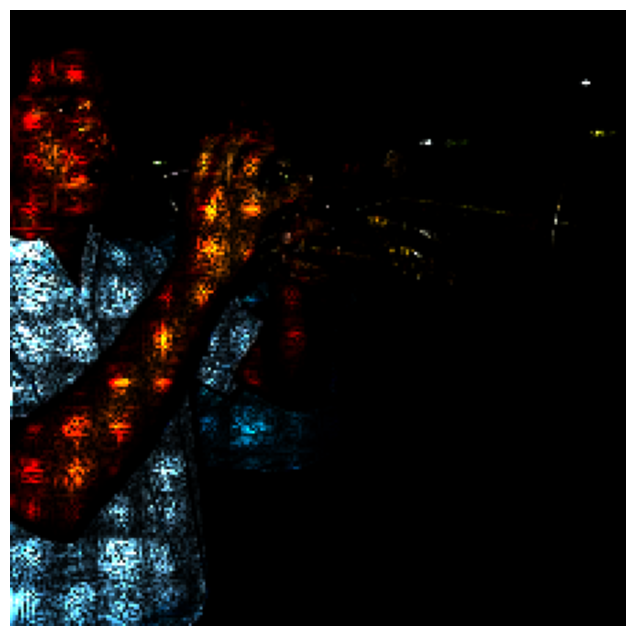

In [36]:
from captum.attr import IntegratedGradients
import torch

ig = IntegratedGradients(lambda x: model(x))


if x.grad is not None:
    x.grad.zero_()

ig_ex = ig.attribute(x, torch.zeros_like(x), target=clid)

vis = x * ig_ex.mean(dim=1).abs() * 100

plt.figure(figsize=(8, 8))
plt.imshow(vis[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")

In [8]:
bcos_model = timm.create_model('vit_base_patch16_clip_224.openai', pretrained=True).cuda()

In [9]:
from typing import Optional
from timm.layers import maybe_add_mask
import types
import torch.nn.functional as F

def attn_forward(
        self,
        x: torch.Tensor,
        attn_mask: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    q, k = self.q_norm(q), self.k_norm(k)

    q = q * self.scale
    attn = q @ k.transpose(-2, -1)
    attn = maybe_add_mask(attn, attn_mask)
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)
    attn = attn.detach()
    x = attn @ v

    x = x.transpose(1, 2).reshape(B, N, C)
    x = self.norm(x)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


def gelu_forward(self, input: torch.Tensor) -> torch.Tensor:
    gelu_original = F.gelu(input)
    gauss = gelu_original / input
    return gauss.detach() * input



# def forward_features(
for blk in bcos_model.blocks:
    blk.attn.forward = types.MethodType(attn_forward, blk.attn)
    blk.mlp.act.forward = types.MethodType(gelu_forward, blk.mlp.act)


In [10]:

if x.grad is not None:
    x.grad.zero_()

out = bcos_model(x)
out[0, 0].backward()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-24.677416..5.586539].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

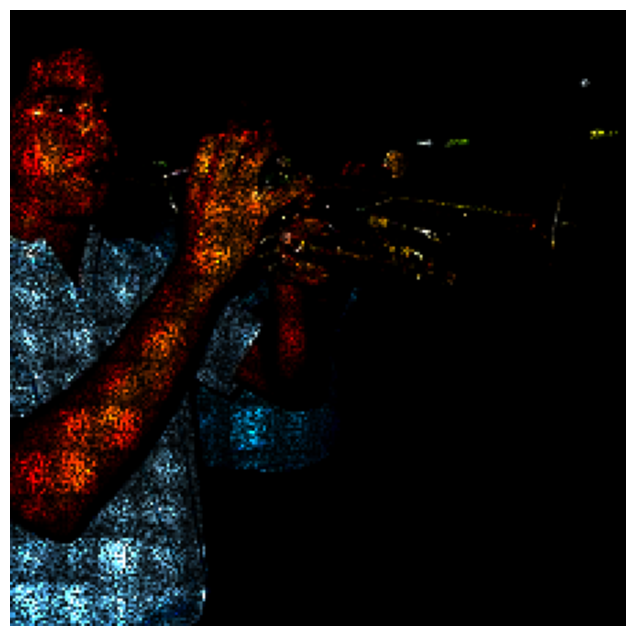

In [34]:
ex_bcos = x * x.grad.mean(dim=1).abs() * 100


plt.figure(figsize=(8, 8))
plt.imshow(ex_bcos[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")